In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.float_format', lambda x: '%.4f' % x)


## Feature Extraction

In [2]:
print("import data")
ordert = pd.read_csv('order_products__train.csv')
orderp = pd.read_csv('order_products__prior.csv')

orders = pd.read_csv('orders.csv')
orders = orders.fillna(value=0)

products = pd.read_csv('products.csv')
aisles = pd.read_csv('aisles.csv')
departments = pd.read_csv('departments.csv')


import data


In [3]:
print("merge orders and order_products__train") 
ordert = pd.merge(ordert, orders, how='left', on=['order_id'])


merge orders and order_products__train


In [4]:
print("merge orders and order_products__prior") 
orders_products = pd.merge(orderp, orders, how='left', on=['order_id'])

del orderp
orders_products.head()

merge orders and order_products__prior


,order_id,product_id,add_to_cart_order,reordered,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2,33120,1,1,202279,prior,3,5,9,8.0000
1,2,28985,2,1,202279,prior,3,5,9,8.0000
2,2,9327,3,0,202279,prior,3,5,9,8.0000
3,2,45918,4,1,202279,prior,3,5,9,8.0000
4,2,30035,5,0,202279,prior,3,5,9,8.0000


In [5]:
# 整理 prior 中 user_product 前一次出現的資訊(mean, std)
# 因為變異數算法為(n-1)為分母，所以填入0，
# 將train和test的購買距離前一次 user_product 的天數取出
# 將train中，組合是否reordered填入(train中，第一次出現的組合就先不理了)

print("days_since_prior_order of user_product preprocessing")

f = {'days_since_prior_order' : ['mean', 'std'], 
     'order_number':['max']} #lsat_order
usersXprod0 = orders_products.groupby(["user_id", "product_id"]).aggregate(f).reset_index()
usersXprod0.columns = ["user_id", "product_id",
                      'up_mean_days_since_prior_order','up_var_days_since_prior_order',
                      "up_last_order"] 
usersXprod0 = usersXprod0.fillna(value = 0)

f = {'order_number' : ['max']}
g1 = orders_products.groupby(["user_id"]).aggregate(f).reset_index()
g1.columns = ["user_id", "up_nb_order"]
g1["up_nb_order"] = g1.up_nb_order + 1 #user_total_order
usersXprod0 = pd.merge(usersXprod0, g1, how='left', on=["user_id"])
del g1

f = lambda x: np.array_split(list(x), 1)[0]
g = orders.groupby('user_id')["days_since_prior_order"].apply(f).reset_index() #user_list_days_since_prior_order
usersXprod0 = pd.merge(usersXprod0, g, how='left', on=["user_id"])
usersXprod0['user_product'] = usersXprod0.product_id + usersXprod0.user_id * 100000

usersXprod0.head()

days_since_prior_order of user_product preprocessing


,user_id,product_id,up_mean_days_since_prior_order,up_var_days_since_prior_order,up_last_order,up_nb_order,days_since_prior_order,user_product
0,1,196,17.6000,10.8033,10,11,"[0.0, 15.0, 21.0, 29.0, 28.0, 19.0, 20.0, 14.0...",100196
1,1,10258,19.5556,9.3956,10,11,"[0.0, 15.0, 21.0, 29.0, 28.0, 19.0, 20.0, 14.0...",110258
2,1,10326,28.0000,0.0000,5,11,"[0.0, 15.0, 21.0, 29.0, 28.0, 19.0, 20.0, 14.0...",110326
3,1,12427,17.6000,10.8033,10,11,"[0.0, 15.0, 21.0, 29.0, 28.0, 19.0, 20.0, 14.0...",112427
4,1,13032,21.6667,7.6376,10,11,"[0.0, 15.0, 21.0, 29.0, 28.0, 19.0, 20.0, 14.0...",113032


In [6]:
prior_order = usersXprod0[["up_last_order","up_nb_order","days_since_prior_order","user_product"]]

d= dict()
i = 0
for i, row in enumerate(prior_order.itertuples(), 1):
    i+=1
    if i%2000000 == 0: print ('order row', i)    
    z = row.user_product
    last = int(row.up_last_order)
    now = int(row.up_nb_order)
    prior = sum(row.days_since_prior_order[last: now])
    d[z] = prior
p = pd.DataFrame.from_dict(d, orient = 'index')

order row 2000000
order row 4000000
order row 6000000
order row 8000000
order row 10000000
order row 12000000


In [7]:
p["user_product"] = p.index
p.columns = ["up_days_since_prior_order", "user_product"]
usersXprod0 = pd.merge(usersXprod0, p, how='left', on=["user_product"])
usersXprod0 = usersXprod0.drop(["up_last_order","up_nb_order","days_since_prior_order","user_product"], axis=1)
usersXprod0.head()


,user_id,product_id,up_mean_days_since_prior_order,up_var_days_since_prior_order,up_days_since_prior_order
0,1,196,17.6000,10.8033,14.0000
1,1,10258,19.5556,9.3956,14.0000
2,1,10326,28.0000,0.0000,97.0000
3,1,12427,17.6000,10.8033,14.0000
4,1,13032,21.6667,7.6376,14.0000


In [8]:
orders = orders[(orders.eval_set != "prior")]
orders = orders[["user_id","eval_set","order_id"]]
usersXprod0 = pd.merge(usersXprod0, orders, how='left', on=["user_id"])

ordert = ordert[["user_id","product_id","reordered"]]
usersXprod0 = pd.merge(usersXprod0, ordert, how='left', on=["user_id", "product_id"])

usersXprod0.reordered = usersXprod0.reordered.replace(to_replace = "nan", value = 0)

#del ordert
#del orders
print("nb of usersXproducts features :", usersXprod0.shape[1])
usersXprod0.head()


nb of usersXproducts features : 8


,user_id,product_id,up_mean_days_since_prior_order,up_var_days_since_prior_order,up_days_since_prior_order,eval_set,order_id,reordered
0,1,196,17.6000,10.8033,14.0000,train,1187899,1.0000
1,1,10258,19.5556,9.3956,14.0000,train,1187899,1.0000
2,1,10326,28.0000,0.0000,97.0000,train,1187899,0.0000
3,1,12427,17.6000,10.8033,14.0000,train,1187899,0.0000
4,1,13032,21.6667,7.6376,14.0000,train,1187899,1.0000


In [9]:
# split train and test

train = usersXprod0[(usersXprod0.eval_set == "train")]
test = usersXprod0[(usersXprod0.eval_set == "test")]
del usersXprod0


In [10]:
# class weighted
y = train[["reordered"]]

class_weight_0 = (y.shape[0] - np.sum(y.reordered)) / y.shape[0]
class_weight_1 = np.sum(y.reordered) / y.shape[0]

print("Class weight of 0 :", class_weight_0)
print("Class weight of 1 :", class_weight_1)


Class weight of 0 : 0.9021997458069414
Class weight of 1 : 0.09780025419305857


## Model Building

In [11]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.cross_validation import cross_val_score
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier, AdaBoostClassifier, VotingClassifier


/Users/Shawn/anaconda/lib/python3.6/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [20]:
def validation(model, X_train, X_val, y_train, y_val):
    model.fit(X_train, y_train)
    print(str(model), "cross_val down")
    y_pred = model.predict(X_val).reshape(y_val.shape[0], 1)
    print('Misclassified samples: %d' % (y_val != y_pred).sum())
    print('Accuracy : %.2f' % ((y_val == y_pred).sum() / y_val.shape[0]))
    print('Accuracy (sklearn): %.2f' % accuracy_score(y_val, y_pred))
    print("=== Confusion Matrix ===")
    print(confusion_matrix(y_val, y_pred, labels = [0,1], sample_weight = None))
    print("=== F1-score ===")
    print(f1_score(y_val, y_pred, labels=[0,1]))
    return y_pred 

### 整理過的testing dataset 去預測
### 拿出以前的商品顧客組合去預測是否reordered    
### 建立一個門檻值去篩選是否購買???
### 選出指定order_id 購買的商品並匯出
def cross_val_and_testing(df, df_test, model, threshold):
    model.fit(train[["up_mean_days_since_prior_order","up_var_days_since_prior_order","up_days_since_prior_order"]],
              train[["reordered"]])
    print ("Fitting Over")
    pred = pd.DataFrame(model.predict_proba(df_test), columns = ["prob_0", "prob_1"])
    df["prediction"] = pred["prob_1"]
    df = df[["order_id", "product_id", "prediction"]]

    con = (df.prediction >= threshold)
    test0_0 = df[~con]
    test0_1 = df[con]
    print("Percent of test0 is 0 :", test0_0.shape[0]/df.shape[0])
    print("Percent of test0 is 1 :", test0_1.shape[0]/df.shape[0])

    f = lambda x: np.array_split(list(set(x)), 1)[0]
    order_prod = test0_1.groupby('order_id')["product_id"].apply(f).reset_index()
    order_id = df.groupby("order_id")["product_id"].apply(f).reset_index()
    submit = pd.merge(order_id[["order_id"]], order_prod, how='left', on=['order_id'])
    return submit


In [13]:
tree = DecisionTreeClassifier(criterion = 'entropy', 
                              max_depth = None, 
                              random_state = 0,
                              class_weight = {1: class_weight_1, 0: class_weight_0})

bc = BaggingClassifier(base_estimator = tree,  
                       n_estimators = 10,  
                       max_samples = 1.0,  
                       max_features = 1.0,  
                       bootstrap = True,  
                       bootstrap_features = False,  
                       oob_score = False,  
                       warm_start = False,  
                       n_jobs = 1,  
                       random_state = None,  
                       verbose = 0)


In [14]:
X_train, X_val, y_train, y_val = train_test_split(train.drop(["reordered", "eval_set"],axis=1),
                                                  train[["reordered"]],
                                                  test_size = 0.1,
                                                  random_state = 0)


### fit model

In [15]:
col = ["user_id", "product_id", "order_id"]
X_train_fit = X_train.drop(col, axis=1)
X_val_fit = X_val.drop(col, axis=1)

y_pred = validation(tree, X_train_fit, X_val_fit, y_train, y_val)


DecisionTreeClassifier(class_weight={1: 0.09780025419305857, 0: 0.9021997458069414},
            criterion='entropy', max_depth=None, max_features=None,
            max_leaf_nodes=None, min_impurity_split=1e-07,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=0,
            splitter='best') cross_val down
Misclassified samples: 92288
Accuracy : 0.89
Accuracy (sklearn): 0.89
=== Confusion Matrix ===
[[743554  20955]
 [ 71333  11625]]
=== F1-score ===
0.201232494937


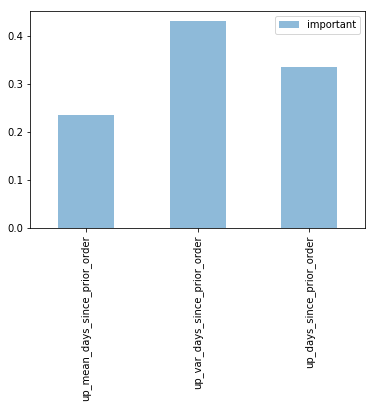

In [16]:
imp = pd.DataFrame(data = tree.feature_importances_,
                   index = X_val_fit.columns,
                   columns = ["important"])
imp.plot.bar(alpha=0.5)
plt.show()

In [17]:
frame = [X_val.reset_index(drop=True), y_val.reset_index(drop=True), pd.DataFrame(y_pred,columns=["pred"])]
result = pd.concat(frame, axis=1)
result['correct'] = result.reordered == \
                                        result.pred
print(result.shape)
result.head()

(847467, 9)


,user_id,product_id,up_mean_days_since_prior_order,up_var_days_since_prior_order,up_days_since_prior_order,order_id,reordered,pred,correct
0,51783,47120,13.0000,0.0000,267.0000,365144,0.0000,0.0000,True
1,165860,13984,3.0000,0.0000,232.0000,352644,0.0000,0.0000,True
2,134148,29660,8.0000,0.0000,20.0000,1345617,1.0000,0.0000,False
3,134744,13176,3.0000,1.4142,2.0000,2563808,1.0000,0.0000,False
4,150536,24373,7.0000,0.0000,70.0000,22021,0.0000,0.0000,True


In [43]:
threshold = 0.025

submit = cross_val_and_testing(df = test,
                               df_test = test[["up_mean_days_since_prior_order","up_var_days_since_prior_order","up_days_since_prior_order"]],
                               model = tree, threshold = threshold)
submit.to_csv("submit_tree.csv", index = False)


Fitting Over
Percent of test0 is 0 : 0.9625491280063361
Percent of test0 is 1 : 0.037450871993663946


In [46]:
submit.isnull().sum()[1]/submit.shape[0]

0.67218666666666671

### 針對users分析

In [ ]:
# True=1, False=0
result.correct = result.correct.astype("category").cat.codes

f = {'correct':['count', 'sum'],
     'reordered':['sum'],
     'pred':['sum']}
g = result.groupby(["user_id"]).aggregate(f).reset_index()
g.columns = ["user_id", "nb_product", "sum_correct", "sum_val", "sum_pred"]
g["percent_reorder"] = g.sum_val/g.nb_product
g["accuracy"] = g.sum_correct/g.nb_product
g.head()


In [ ]:
def scatter_plot(df, dim1, dim2):
    tocluster = pd.DataFrame(df[[dim1,dim2]])
    print ("Shape of tocluster", tocluster.shape)
    print (tocluster.head())

    fig = plt.figure(figsize=(8,8))
    plt.plot(tocluster[dim1], tocluster[dim2], 'o', markersize=4, color='blue', alpha=0.03, label='class1')

    plt.xlabel(dim1)
    plt.ylabel(dim2)
    plt.legend()
    plt.show()
    return tocluster

In [ ]:
a = scatter_plot(df=g, dim1='percent_reorder', dim2='accuracy')

In [ ]:
high = g[(g.sum_val > 1)&(g.accuracy > 0.9)&(g.percent_reorder > 0.5)]
print (high.shape[0])